<a href="https://colab.research.google.com/github/natskiu/Nasa-Battery/blob/main/Data_Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data and feature extraction

In this notebook, we import and process the raw experimental data to extract the required features. We then store these into a Pandas dataframe which can be exported to a csv file for future use.

## Importing libraries and loading data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#this is a comment
import scipy.io as sio
import pandas as pd

In [2]:
# raw=true is important so you download the file rather than the webpage.
#!wget https://github.com/natskiu/Nasa-Battery/blob/main/Data/B0005.mat?raw=true
# rename the file - we are importing the data for one battery, B0005.
#!mv B0005.mat\?raw\=true B0005.mat
# update scipy
#!pip install -U -q scipy
# Load the data
from scipy import io
import os
datapath = 'Data/'
v = io.loadmat(datapath + 'B0005.mat')

## Preprocessing raw data

### Raw data structure 
The raw battery data (defined as v) is a nested dictionary with keys = ['__header__', '__version__', '__globals__', 'B0005']

In [3]:
v.keys()

dict_keys(['__header__', '__version__', '__globals__', 'B0005'])

In [4]:
# This extracts the data for all cycles in the form of a nested numpy array.
cycles = np.vstack(v['B0005'][0,0])
type(cycles)

numpy.ndarray

In [5]:
#the middle index indicates the charge/discharge number. 
# For example, cycles[0,0][3] gets the data for the first charge, cycles[0,1][3] gets the data for the first discharge, etc.
cycles[0,0][3].shape

(1, 1)

In [6]:
def capacity_vectorizer(discharge_indices, cycles=cycles):
  """
  inputs
  -------------------
  discharge_indices: list, with indices of discharging cycles

  outputs
  -------------------
  None (modifies cycles)

  Note: only run this function ONCE
  """
  for discharge_index in discharge_indices:
    N = (cycles[0,discharge_index][3][0,0][5]).shape[1] # gets number of entries
    capacity_scalar = cycles[0,discharge_index][3][0,0][6]
    cycles[0,discharge_index][3][0,0][6] = np.pad(capacity_scalar.flatten().tolist(), (0, N-1), 'constant')
    vectorized_cycles = cycles
  return vectorized_cycles


In [7]:
def get_indices(cycles, is_charge=True):
  index_list =[]
  if is_charge:
    label = 'charge'
  else:
    label = 'discharge'
  for i in range(cycles.shape[1]):
    if cycles[0,i][0] == np.array([label]):
      index_list.append(i)

  return index_list

In [8]:
discharge_indices = get_indices(cycles, is_charge = False)
print(discharge_indices)
len(discharge_indices)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 24, 26, 28, 30, 32, 34, 36, 38, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77, 81, 85, 89, 93, 97, 101, 105, 109, 113, 117, 121, 125, 129, 133, 135, 139, 143, 147, 149, 153, 157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197, 201, 205, 209, 213, 215, 219, 223, 227, 231, 235, 239, 243, 247, 251, 255, 259, 263, 265, 269, 273, 277, 281, 285, 289, 293, 297, 301, 305, 309, 312, 315, 319, 323, 327, 331, 335, 339, 343, 347, 351, 355, 359, 363, 366, 370, 374, 378, 382, 386, 390, 394, 398, 402, 406, 410, 414, 418, 422, 426, 430, 432, 436, 440, 444, 448, 452, 456, 460, 464, 468, 472, 476, 480, 482, 484, 488, 492, 496, 500, 504, 508, 512, 516, 520, 524, 528, 532, 536, 540, 544, 547, 551, 555, 559, 563, 567, 571, 575, 579, 583, 587, 591, 595, 599, 603, 607, 611, 613]


168

In [9]:
charge_indices = get_indices(cycles, is_charge=True)
charge_indices.remove(22)
charge_indices.remove(615)
print(charge_indices)
len(charge_indices)

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 23, 25, 27, 29, 31, 33, 35, 37, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79, 83, 84, 87, 91, 95, 99, 103, 107, 111, 115, 119, 123, 127, 131, 134, 137, 141, 145, 148, 151, 155, 159, 163, 167, 171, 175, 179, 183, 187, 191, 195, 199, 203, 207, 211, 214, 217, 221, 225, 229, 233, 237, 241, 245, 249, 253, 257, 261, 264, 267, 271, 275, 279, 283, 287, 291, 295, 299, 303, 307, 314, 317, 321, 325, 329, 333, 337, 341, 345, 349, 353, 357, 361, 365, 368, 372, 376, 380, 384, 388, 392, 396, 400, 404, 408, 412, 416, 420, 424, 428, 431, 434, 438, 442, 446, 450, 454, 458, 462, 466, 470, 474, 478, 481, 483, 486, 490, 494, 498, 502, 506, 510, 514, 518, 522, 526, 530, 534, 538, 542, 546, 549, 553, 557, 561, 565, 569, 573, 577, 581, 585, 589, 593, 597, 601, 605, 609, 612]


168

In [10]:
"This is how you extract all the features from cycles"
#np.vstack(cycles[0,0][3][0,0])[0]

'This is how you extract all the features from cycles'

In [11]:
new_cycles = capacity_vectorizer(discharge_indices)

In [12]:
new_cycles[0,1][3][0,0][6].shape

(197,)

In [13]:
def cycle_plotter(cycle_indices):
  features = ['voltage_measured', 'currenet_measured', 'temperature', 'current_load/charge', 'voltage_load/charge']  
  for i, label in enumerate(features):
    for cycle_index in cycle_indices:
      y = np.vstack(new_cycles[0,cycle_index][3][0,0])[i]
      x = np.vstack(new_cycles[0,cycle_index][3][0,0])[5]
      #f=plt.figure()
      plt.ylabel(label)
      plt.xlabel('time')
      plt.title(label)
      plt.plot(x, y,marker='o' ,markersize = 3, linestyle='',label=('cycle'+str(cycle_index)))
      plt.legend()
    plt.show()

In [14]:
print(discharge_indices)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 24, 26, 28, 30, 32, 34, 36, 38, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77, 81, 85, 89, 93, 97, 101, 105, 109, 113, 117, 121, 125, 129, 133, 135, 139, 143, 147, 149, 153, 157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197, 201, 205, 209, 213, 215, 219, 223, 227, 231, 235, 239, 243, 247, 251, 255, 259, 263, 265, 269, 273, 277, 281, 285, 289, 293, 297, 301, 305, 309, 312, 315, 319, 323, 327, 331, 335, 339, 343, 347, 351, 355, 359, 363, 366, 370, 374, 378, 382, 386, 390, 394, 398, 402, 406, 410, 414, 418, 422, 426, 430, 432, 436, 440, 444, 448, 452, 456, 460, 464, 468, 472, 476, 480, 482, 484, 488, 492, 496, 500, 504, 508, 512, 516, 520, 524, 528, 532, 536, 540, 544, 547, 551, 555, 559, 563, 567, 571, 575, 579, 583, 587, 591, 595, 599, 603, 607, 611, 613]


In [15]:
#cycle_plotter([1,484])

## Functions to extract features from original dataset

### Features
#### Discharging cycle

1. Time taken for discharging temperature to reach max value (set threshold ~ 1000s)
2. Max. temperature during discharge
3. Slope for temperature during discharge 
(max_temp - initial_temp)/(time_at_max_temp)
4. Time for voltage_measured to drop below 3 Volts
5. Slope for first 20 data points of voltage_measured

#### Charging cycle

6. Time  taken for charging temperature to reach max value (set threshold ~ 1000s)
7. Max. temperature during charge

### Label
* Capacity recorded for each discharging cycle


In [16]:
def extract_feature_1_2_6_7(indices, cycles, threshold = 1000):
  '''
  This function returns two lists - first is the time to reach the maximum 
  temperature for each cycle, second is the maximum temperature for each cycle.
  This can be used for both charging and discharging cycles, just input the 
  correct list of indices. NB for charging cycles remove the extra two cycles
  first
  --------
  indices: list, a list that can be generated using function get_indices 
          containing indices of discharging/ charging cycles
  cycles: array, an array containing all the data of the battery. It has to be
          preprocessed to be stackable and indexable.
  threshold: int, set by default to 1000 to avoid taking in to account of 
             anomalous max temp data
  outputs
  --------
  max_temp_time_list: list, a list that contains the corresponding time of the 
                      maximum temperature in every discharging/ charging cycle
  max_temp_list: list, a list that contains the maximum temperature in every
                 discharging/ charging cycle 
                
  note: the lengths of the lists should be the same = the length of the input 
  list of indices.
  '''
  max_temp_time_list = []
  max_temp_list = []
  for index in indices:
    times = new_cycles[0,index][3][0,0][5].flatten().tolist()
    temps = new_cycles[0,index][3][0,0][2].flatten().tolist()
    threshold_index =  next(i for i, time in enumerate(times) if time > threshold)
    temps = temps[threshold_index:]
    times = times[threshold_index:]
    max_temp = max(temps)
    max_temp_index = temps.index(max_temp)
    max_temp_time_list.append(times[max_temp_index])
    max_temp_list.append(max_temp)
  return max_temp_time_list, max_temp_list


In [17]:
def extract_feature_3(discharge_indices, cycles):
    """
    Inputs
    --------
    indices: list, a list that can be generated using function get_indices 
          containing indices of discharging/ charging cycles
    cycles: array, an array containing all the data of the battery. It has to be
          preprocessed to be stackable and indexable.
    threshold: int, set by default to 1000 to avoid taking in to account of 
             anomalous max temp data

    """
    max_temp_times, max_temps = extract_feature_1_2_6_7(discharge_indices, cycles)
    initial_temps = []
    for discharge_index in discharge_indices:
      initial_temp = new_cycles[0,discharge_index][3][0,0][2].flatten().tolist()[0]
      initial_temps.append(initial_temp)
    slopes = (np.array(max_temps)-np.array(initial_temps))/np.array(max_temp_times)
    return slopes.tolist()

In [18]:
def extract_feature_4(dataset=new_cycles, indices=discharge_indices, threshold=500, voltage_cutoff=3): #time for voltage_measured to drop below 3V during discharge
  '''
  Feature 4 is the time for voltage_measured to drop below 3V during discharge.
  **Input**
  data = full cycle data
  indices = list of indices from which we would like to extract features
  threshold = time from which to start checking (to avoid anomalous data at the start)

  **Output**
  feature_4_list = list of feature values for each cycle
  '''
  feature_4_list = []

  for index in indices:
    voltage_measured_list = (dataset[0,index][3][0,0][0]).flatten().tolist() #turn voltage_measured numpy array into list
    time_list = (dataset[0,index][3][0,0][5]).flatten().tolist() #turn time vector into list
    threshold_index = next(i for i, time in enumerate(time_list) if time > threshold) #getting index of threshold
    voltage_measured_list = voltage_measured_list[threshold_index:] #shortening voltage_measured_list and time_list
    time_list = time_list[threshold_index:]
    index_3V = next(i for i, voltage in enumerate(voltage_measured_list) if voltage < voltage_cutoff) #getting index of when 3V is reached
    feature_4_list.append(time_list[index_3V]) #getting the corresponding time

  return feature_4_list


In [24]:
def extract_feature_5(dataset=new_cycles, indices=discharge_indices, start_time=100, end_time=500): #slope of voltage_measured during discharge
  '''
  Feature 5 is the slope of voltage_measured using the first N data points.
  **Input**
  data = full cycle data
  indices = list of indices from which we would like to extract features
  start_time = start time to measure slope
  end_time = end time to measure slope

  **Output**
  feature_5_list = list of feature values for each cycle
  '''
  feature_5_list = []

  for index in indices:
    voltage_measured_list = (dataset[0,index][3][0,0][0]).flatten().tolist() #turn voltage_measured numpy array into list
    time_list = (dataset[0,index][3][0,0][5]).flatten().tolist() #turn time vector into list
    start_time_index = min(range(len(time_list)), key=lambda i: abs(time_list[i]-start_time)) #get index of start_time
    end_time_index = min(range(len(time_list)), key=lambda i: abs(time_list[i]-end_time)) #get index of end_time
    slope = (voltage_measured_list[end_time_index] - voltage_measured_list[start_time_index])/(time_list[end_time_index] - time_list[start_time_index])
    feature_5_list.append(slope)
  
  return feature_5_list

In [20]:
def extract_label(dataset=new_cycles, indices=discharge_indices):
  labels = []
  for index in indices:
    label = (dataset[0,index][3][0,0][6]).flatten().tolist()
    labels.append(label[0])
  return labels

## Data Exploration

In [25]:
feature_1_list, feature_2_list = extract_feature_1_2_6_7(get_indices(new_cycles, is_charge=False), new_cycles)
feature_6_list, feature_7_list = extract_feature_1_2_6_7(charge_indices, new_cycles)
feature_3_list = extract_feature_3(get_indices(new_cycles, is_charge=False), new_cycles)
feature_4_list = extract_feature_4(new_cycles, get_indices(new_cycles, is_charge=False))
feature_5_list = extract_feature_5(new_cycles, get_indices(new_cycles, is_charge=False))
label_list = extract_label(new_cycles, get_indices(new_cycles, is_charge=False))

In [26]:
features_dict = {'time_for_max_temp_D':feature_1_list,'max_temp_D':feature_2_list,
                 'slope_temp_D': feature_3_list, 'time_voltage_measured_below3_D':feature_4_list,
                 'slope_voltage_measured_D':feature_5_list, 'time_for_max_temp_C':feature_6_list,
                 'max_temp_C':feature_7_list, 'capacity': label_list}

In [27]:
df = pd.DataFrame(data = features_dict)
cutoff = df['capacity'].iloc[0]*0.8 # 1.2995411945727102
df[df.capacity > cutoff]

,time_for_max_temp_D,max_temp_D,slope_temp_D,time_voltage_measured_below3_D,slope_voltage_measured_D,time_for_max_temp_C,max_temp_C,capacity
0,3366.781,38.982181,0.004352,3287.969,-0.000339,1006.094,27.317609,1.856487
1,3348.735,39.033398,0.004281,3269.688,-0.000341,3447.609,29.203048,1.846327
2,3329.281,38.818797,0.004231,3250.437,-0.000341,3419.156,29.334557,1.835349
3,3329.500,38.762305,0.004237,3250.563,-0.000342,3421.593,29.255008,1.835263
4,3327.531,38.665393,0.004250,3248.766,-0.000342,3395.125,29.129995,1.834646
...,...,...,...,...,...,...,...,...
97,2719.750,40.432676,0.005947,2614.797,-0.000412,2488.891,29.804975,1.501545
98,2700.485,40.314539,0.005957,2595.563,-0.000413,2451.735,29.815187,1.490844
99,2691.656,40.386662,0.005986,2586.781,-0.000414,2440.671,29.836685,1.485868
102,2691.360,40.584997,0.006034,2576.953,-0.000411,2391.234,29.817445,1.485904


In [28]:
df.describe()

,time_for_max_temp_D,max_temp_D,slope_temp_D,time_voltage_measured_below3_D,slope_voltage_measured_D,time_for_max_temp_C,max_temp_C,capacity
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,2846.875994,39.845110,0.005613,2754.208619,-0.000397,2658.187280,29.456190,1.572502
std,342.720870,1.118020,0.001053,362.104457,0.000046,556.328245,0.692348,0.190413
min,2327.750000,37.801336,0.004146,2222.094000,-0.000474,1004.344000,23.888926,1.287453
25%,2520.270000,38.804674,0.004540,2408.808500,-0.000439,2174.832000,29.200590,1.390021
50%,2818.523500,40.080753,0.005652,2713.586000,-0.000397,2588.718500,29.465142,1.557085
75%,3195.621250,40.865238,0.006538,3132.226750,-0.000348,3203.429000,29.827732,1.769163
max,3366.781000,41.450232,0.007380,3290.750000,-0.000332,3494.703000,31.187718,1.856487


In [29]:
discharge_indices[30]

85

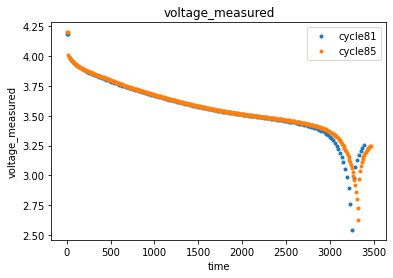

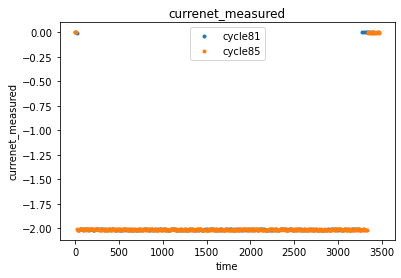

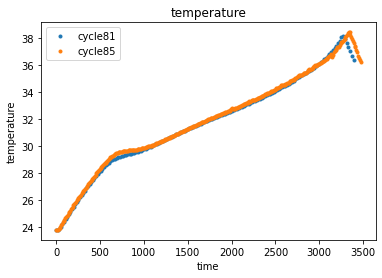

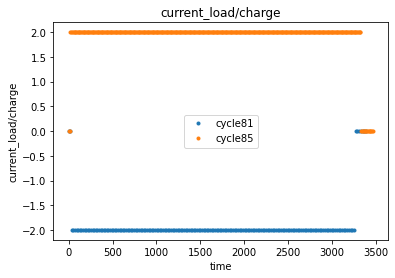

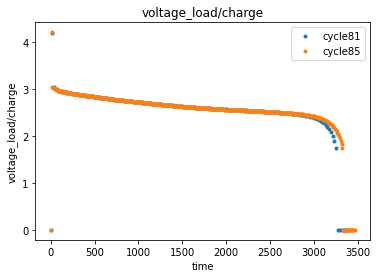

In [68]:
cycle_plotter([81, 85])

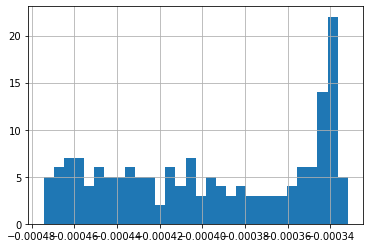

In [30]:
df['slope_voltage_measured_D'].hist(bins=30)

In [33]:
corr_matrix = df.corr()
corr_matrix

,time_for_max_temp_D,max_temp_D,slope_temp_D,time_voltage_measured_below3_D,slope_voltage_measured_D,time_for_max_temp_C,max_temp_C,capacity
time_for_max_temp_D,1.000000,-0.933960,-0.994783,0.999710,0.995416,0.878305,-0.508610,0.999813
max_temp_D,-0.933960,1.000000,0.921307,-0.937172,-0.926050,-0.851372,0.578307,-0.935272
slope_temp_D,-0.994783,0.921307,1.000000,-0.994703,-0.996371,-0.883042,0.469977,-0.994994
time_voltage_measured_below3_D,0.999710,-0.937172,-0.994703,1.000000,0.995519,0.878788,-0.511434,0.999804
slope_voltage_measured_D,0.995416,-0.926050,-0.996371,0.995519,1.000000,0.881756,-0.483197,0.996180
time_for_max_temp_C,0.878305,-0.851372,-0.883042,0.878788,0.881756,1.000000,-0.195099,0.878075
max_temp_C,-0.508610,0.578307,0.469977,-0.511434,-0.483197,-0.195099,1.000000,-0.510329
capacity,0.999813,-0.935272,-0.994994,0.999804,0.996180,0.878075,-0.510329,1.000000


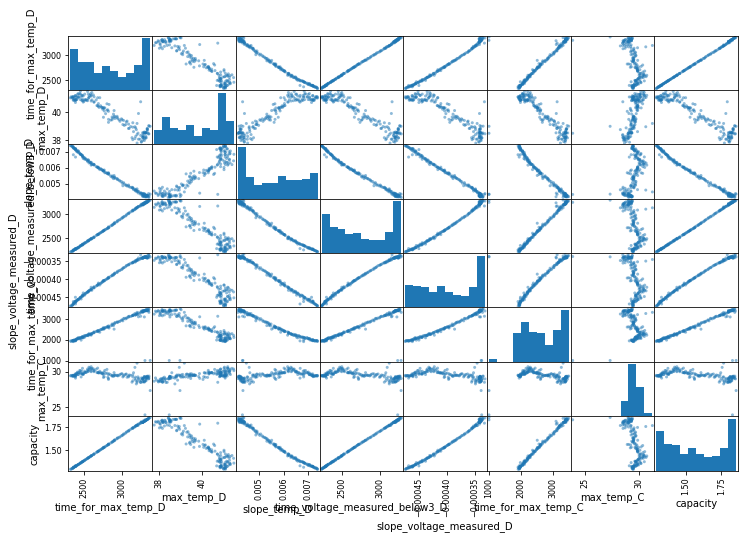

In [35]:
from pandas.plotting import scatter_matrix

attributes = df.columns
scatter_matrix(df[attributes], figsize=(12,8))
plt.show()

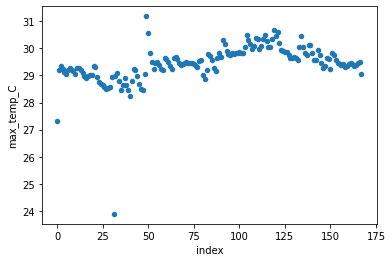

In [ ]:
df.reset_index().plot(kind= 'scatter', x = 'index', y = 'max_temp_C')

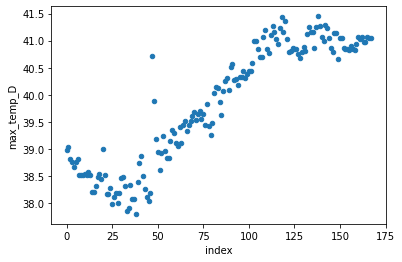

In [ ]:
df.reset_index().plot(kind= 'scatter', x = 'index', y = 'max_temp_D')

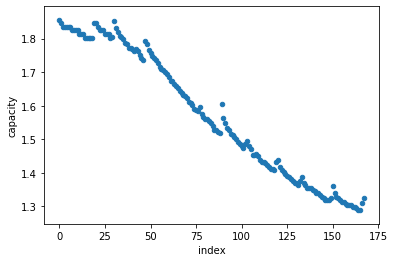

In [36]:
df.reset_index().plot(kind= 'scatter', x = 'index', y = 'capacity')